# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from workspace_utils import active_session 
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        #normalization
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [6]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4        # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 2  
LEARN_NUM = 3  
EPSILON = 1.0  
EPSILON_DECAY = 0.999

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON
        self.epsilon_decay=EPSILON_DECAY


        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.t_step = 0
    
    def step(self, shared_buffer):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        self.t_step = (self.t_step + 1) % LEARN_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(shared_buffer) > BATCH_SIZE:
                for _ in range(LEARN_NUM):
                    experiences = shared_buffer.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
            
            

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ----------------------- update target networks ----------------------- #
        
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
         # --------------------- and update epsilon decay ----------------------- #
        if self.epsilon_decay > 0:
            self.epsilon=self.epsilon*self.epsilon_decay

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [9]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Magent():
    def __init__(self,state_size,action_size,random_seed,num_agents):
        self.num_agents=num_agents
        self.mul_agent=[Agent(state_size,action_size,random_seed) for i in range(self.num_agents)]
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        #add to shared replay buffer
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
        for agent in self.mul_agent:
            agent.step(self.memory)

    def act(self, states, add_noise=True):
        new_actions =[np.squeeze(agent.act(np.expand_dims(state, axis=0), add_noise), axis=0) for agent, state in zip(self.mul_agent, states)]
        return np.stack(new_actions)

    def reset(self):
        for agent in self.mul_agent:
            agent.reset()
            


In [11]:
magent = Magent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=42)

In [12]:
def ddpg(n_episodes=5000, max_t=1000, print_every=100):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    episode_score = []                          
  
    scores_window = deque(maxlen=100)             
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        
        magent.reset()
        for t in range(max_t):
            actions = magent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            #    agent.step(state, action, reward, next_state, done)        
            magent.step(states, actions, rewards, next_states, dones)  
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        episode_score.append(np.max(scores))           # save mean score for the episode
        scores_window.append(np.max(scores))         # save episode score to window queue         
        print('\rEpisode {} Max: {:.1f}\tWindow Avg: {:.1f}'.format(i_episode, np.max(scores), np.mean(scores_window)))
        if (i_episode >100) and (np.mean(scores_window)>=0.5):
            for i, agent in enumerate(magent.mul_agent):
                torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_{i}.pth')
                torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_{i}.pth')
            #torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            #torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')   
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))            
            break
    return episode_score, scores_window

In [13]:
with active_session():
    episode_score_, scores_window_=ddpg()

Episode 1 Max: 0.0	Window Avg: 0.0
Episode 2 Max: 0.0	Window Avg: 0.0
Episode 3 Max: 0.0	Window Avg: 0.0
Episode 4 Max: 0.0	Window Avg: 0.0
Episode 5 Max: 0.1	Window Avg: 0.0
Episode 6 Max: 0.0	Window Avg: 0.0
Episode 7 Max: 0.0	Window Avg: 0.0
Episode 8 Max: 0.0	Window Avg: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 9 Max: 0.0	Window Avg: 0.0
Episode 10 Max: 0.0	Window Avg: 0.0
Episode 11 Max: 0.0	Window Avg: 0.0
Episode 12 Max: 0.0	Window Avg: 0.0
Episode 13 Max: 0.0	Window Avg: 0.0
Episode 14 Max: 0.0	Window Avg: 0.0
Episode 15 Max: 0.0	Window Avg: 0.0
Episode 16 Max: 0.0	Window Avg: 0.0
Episode 17 Max: 0.0	Window Avg: 0.0
Episode 18 Max: 0.0	Window Avg: 0.0
Episode 19 Max: 0.0	Window Avg: 0.0
Episode 20 Max: 0.0	Window Avg: 0.0
Episode 21 Max: 0.0	Window Avg: 0.0
Episode 22 Max: 0.0	Window Avg: 0.0
Episode 23 Max: 0.0	Window Avg: 0.0
Episode 24 Max: 0.0	Window Avg: 0.0
Episode 25 Max: 0.0	Window Avg: 0.0
Episode 26 Max: 0.0	Window Avg: 0.0
Episode 27 Max: 0.0	Window Avg: 0.0
Episode 28 Max: 0.0	Window Avg: 0.0
Episode 29 Max: 0.0	Window Avg: 0.0
Episode 30 Max: 0.0	Window Avg: 0.0
Episode 31 Max: 0.0	Window Avg: 0.0
Episode 32 Max: 0.0	Window Avg: 0.0
Episode 33 Max: 0.0	Window Avg: 0.0
Episode 34 Max: 0.0	Window Avg: 0.0
Episode 35 Max: 0.0	Window Avg: 0.0
Episode 36 Max: 0.0	Window Av

Episode 233 Max: 0.0	Window Avg: 0.0
Episode 234 Max: 0.0	Window Avg: 0.0
Episode 235 Max: 0.0	Window Avg: 0.0
Episode 236 Max: 0.0	Window Avg: 0.0
Episode 237 Max: 0.0	Window Avg: 0.0
Episode 238 Max: 0.0	Window Avg: 0.0
Episode 239 Max: 0.0	Window Avg: 0.0
Episode 240 Max: 0.0	Window Avg: 0.0
Episode 241 Max: 0.0	Window Avg: 0.0
Episode 242 Max: 0.0	Window Avg: 0.0
Episode 243 Max: 0.0	Window Avg: 0.0
Episode 244 Max: 0.0	Window Avg: 0.0
Episode 245 Max: 0.0	Window Avg: 0.0
Episode 246 Max: 0.0	Window Avg: 0.0
Episode 247 Max: 0.0	Window Avg: 0.0
Episode 248 Max: 0.0	Window Avg: 0.0
Episode 249 Max: 0.0	Window Avg: 0.0
Episode 250 Max: 0.0	Window Avg: 0.0
Episode 251 Max: 0.0	Window Avg: 0.0
Episode 252 Max: 0.0	Window Avg: 0.0
Episode 253 Max: 0.0	Window Avg: 0.0
Episode 254 Max: 0.0	Window Avg: 0.0
Episode 255 Max: 0.0	Window Avg: 0.0
Episode 256 Max: 0.0	Window Avg: 0.0
Episode 257 Max: 0.0	Window Avg: 0.0
Episode 258 Max: 0.0	Window Avg: 0.0
Episode 259 Max: 0.1	Window Avg: 0.0
E

Episode 455 Max: 0.1	Window Avg: 0.0
Episode 456 Max: 0.0	Window Avg: 0.0
Episode 457 Max: 0.1	Window Avg: 0.0
Episode 458 Max: 0.0	Window Avg: 0.0
Episode 459 Max: 0.1	Window Avg: 0.0
Episode 460 Max: 0.0	Window Avg: 0.0
Episode 461 Max: 0.0	Window Avg: 0.0
Episode 462 Max: 0.1	Window Avg: 0.0
Episode 463 Max: 0.0	Window Avg: 0.0
Episode 464 Max: 0.0	Window Avg: 0.0
Episode 465 Max: 0.0	Window Avg: 0.0
Episode 466 Max: 0.0	Window Avg: 0.0
Episode 467 Max: 0.0	Window Avg: 0.0
Episode 468 Max: 0.0	Window Avg: 0.0
Episode 469 Max: 0.0	Window Avg: 0.0
Episode 470 Max: 0.0	Window Avg: 0.0
Episode 471 Max: 0.0	Window Avg: 0.0
Episode 472 Max: 0.0	Window Avg: 0.0
Episode 473 Max: 0.0	Window Avg: 0.0
Episode 474 Max: 0.0	Window Avg: 0.0
Episode 475 Max: 0.1	Window Avg: 0.0
Episode 476 Max: 0.0	Window Avg: 0.0
Episode 477 Max: 0.0	Window Avg: 0.0
Episode 478 Max: 0.0	Window Avg: 0.0
Episode 479 Max: 0.0	Window Avg: 0.0
Episode 480 Max: 0.0	Window Avg: 0.0
Episode 481 Max: 0.0	Window Avg: 0.0
E

Episode 677 Max: 0.0	Window Avg: 0.0
Episode 678 Max: 0.0	Window Avg: 0.0
Episode 679 Max: 0.0	Window Avg: 0.0
Episode 680 Max: 0.0	Window Avg: 0.0
Episode 681 Max: 0.0	Window Avg: 0.0
Episode 682 Max: 0.0	Window Avg: 0.0
Episode 683 Max: 0.0	Window Avg: 0.0
Episode 684 Max: 0.0	Window Avg: 0.0
Episode 685 Max: 0.0	Window Avg: 0.0
Episode 686 Max: 0.0	Window Avg: 0.0
Episode 687 Max: 0.0	Window Avg: 0.0
Episode 688 Max: 0.0	Window Avg: 0.0
Episode 689 Max: 0.0	Window Avg: 0.0
Episode 690 Max: 0.0	Window Avg: 0.0
Episode 691 Max: 0.0	Window Avg: 0.0
Episode 692 Max: 0.0	Window Avg: 0.0
Episode 693 Max: 0.0	Window Avg: 0.0
Episode 694 Max: 0.1	Window Avg: 0.0
Episode 695 Max: 0.0	Window Avg: 0.0
Episode 696 Max: 0.0	Window Avg: 0.0
Episode 697 Max: 0.0	Window Avg: 0.0
Episode 698 Max: 0.0	Window Avg: 0.0
Episode 699 Max: 0.0	Window Avg: 0.0
Episode 700 Max: 0.0	Window Avg: 0.0
Episode 701 Max: 0.0	Window Avg: 0.0
Episode 702 Max: 0.0	Window Avg: 0.0
Episode 703 Max: 0.0	Window Avg: 0.0
E

Episode 899 Max: 0.1	Window Avg: 0.0
Episode 900 Max: 0.0	Window Avg: 0.0
Episode 901 Max: 0.0	Window Avg: 0.0
Episode 902 Max: 0.0	Window Avg: 0.0
Episode 903 Max: 0.0	Window Avg: 0.0
Episode 904 Max: 0.0	Window Avg: 0.0
Episode 905 Max: 0.0	Window Avg: 0.0
Episode 906 Max: 0.0	Window Avg: 0.0
Episode 907 Max: 0.0	Window Avg: 0.0
Episode 908 Max: 0.0	Window Avg: 0.0
Episode 909 Max: 0.0	Window Avg: 0.0
Episode 910 Max: 0.1	Window Avg: 0.0
Episode 911 Max: 0.0	Window Avg: 0.0
Episode 912 Max: 0.0	Window Avg: 0.0
Episode 913 Max: 0.0	Window Avg: 0.0
Episode 914 Max: 0.0	Window Avg: 0.0
Episode 915 Max: 0.0	Window Avg: 0.0
Episode 916 Max: 0.1	Window Avg: 0.0
Episode 917 Max: 0.0	Window Avg: 0.0
Episode 918 Max: 0.0	Window Avg: 0.0
Episode 919 Max: 0.0	Window Avg: 0.0
Episode 920 Max: 0.0	Window Avg: 0.0
Episode 921 Max: 0.1	Window Avg: 0.0
Episode 922 Max: 0.1	Window Avg: 0.0
Episode 923 Max: 0.0	Window Avg: 0.0
Episode 924 Max: 0.1	Window Avg: 0.0
Episode 925 Max: 0.0	Window Avg: 0.0
E

Episode 1118 Max: 0.1	Window Avg: 0.1
Episode 1119 Max: 0.1	Window Avg: 0.1
Episode 1120 Max: 0.2	Window Avg: 0.1
Episode 1121 Max: 0.1	Window Avg: 0.1
Episode 1122 Max: 0.1	Window Avg: 0.1
Episode 1123 Max: 0.1	Window Avg: 0.1
Episode 1124 Max: 0.1	Window Avg: 0.1
Episode 1125 Max: 0.1	Window Avg: 0.1
Episode 1126 Max: 0.1	Window Avg: 0.1
Episode 1127 Max: 0.2	Window Avg: 0.1
Episode 1128 Max: 0.1	Window Avg: 0.1
Episode 1129 Max: 0.1	Window Avg: 0.1
Episode 1130 Max: 0.2	Window Avg: 0.1
Episode 1131 Max: 0.1	Window Avg: 0.1
Episode 1132 Max: 0.2	Window Avg: 0.1
Episode 1133 Max: 0.1	Window Avg: 0.1
Episode 1134 Max: 0.2	Window Avg: 0.1
Episode 1135 Max: 0.2	Window Avg: 0.1
Episode 1136 Max: 0.2	Window Avg: 0.1
Episode 1137 Max: 0.2	Window Avg: 0.1
Episode 1138 Max: 0.1	Window Avg: 0.1
Episode 1139 Max: 0.2	Window Avg: 0.1
Episode 1140 Max: 0.1	Window Avg: 0.1
Episode 1141 Max: 0.1	Window Avg: 0.1
Episode 1142 Max: 0.1	Window Avg: 0.1
Episode 1143 Max: 0.1	Window Avg: 0.1
Episode 1144

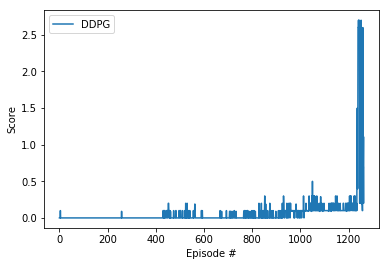

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_score_)), episode_score_, label='DDPG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()